<a href="https://colab.research.google.com/github/fbison/InferenciaDeHabilidadeTRI/blob/main/InferenciaTRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, nan, nan, nan, nan, nan]


Saving parametros_enem.txt to parametros_enem (20).txt


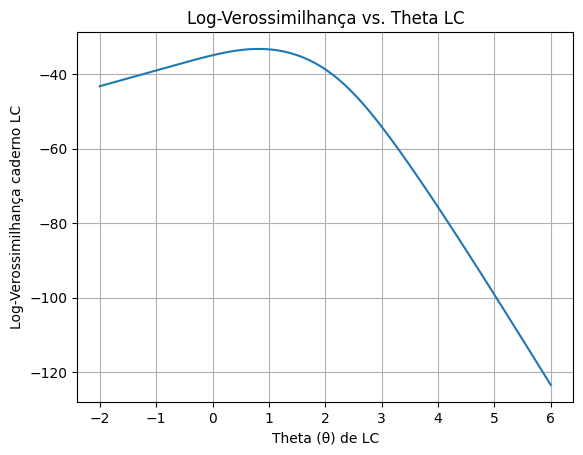

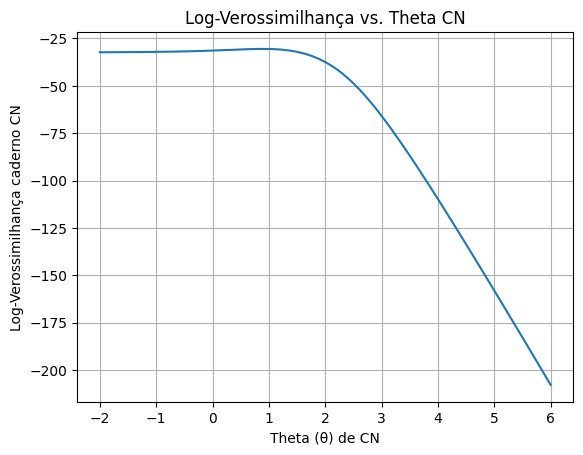

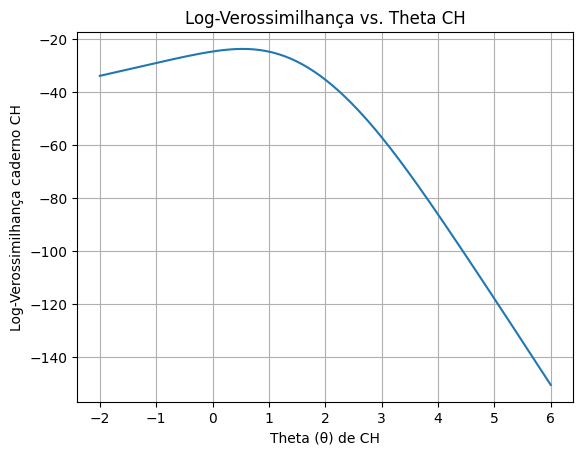

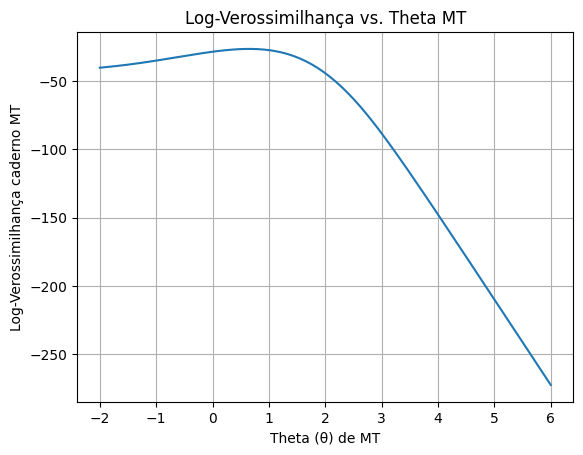

MT
Shapes->A (45,): B=(45,), C=(45,) X=(45,)
CN
Shapes->A (45,): B=(45,), C=(45,) X=(45,)
CH
Shapes->A (45,): B=(45,), C=(45,) X=(45,)
LC
Shapes->A (45,): B=(45,), C=(45,) X=(45,)
MT:
0.6497875848004442
CN:
0.8847920352381583
CH:
0.5354772070429226
LC:
0.8181264027572654


In [ ]:
import numpy as np;
notebooks= ('LC', 'CN', 'CH', 'MT', 'ES', 'IN')
def generate_array_ofBytes(string):
  # Divide a string em uma lista de strings separadas por espaços.
  list_of_strings = string.split()
  array = []

  for element in list_of_strings:
    if element == 'NaN':
      array.append(float('NaN'))
    else:
      array.append(int(element))
  # Retorna o array de inteiros.
  return array

def parse_values(input_string):
    # Dividir a string em uma lista de valores
    values = input_string.split()

    if len(values) != 3:
        raise ValueError("A string deve conter exatamente três valores numéricos separados por espaços.")

    # Atribuir os valores às variáveis A, B, e C
    a = float(values[0])
    b = float(values[1])
    c= float(values[2])

    return [a], [b], [c]

def read_file(filename):
  with open(filename, 'r') as f:
    lines = f.readlines()
  return lines

def create_dict(lines, X):
  dict = {}
  i=0
  for line in lines:
    if line.startswith(notebooks):
      key= line[0:2]
      A, B, C = parse_values(line[8:])
      if not (key in dict):
        dict[key] = {}
        dict[key]['A'] = []
        dict[key]['B'] = []
        dict[key]['C'] = []
        dict[key]['X'] = []
      dict[key]['A'].append(A)
      dict[key]['B'].append(B)
      dict[key]['C'].append(C)
      dict[key]['X'].append(X[i])
      i=i+1
  return dict

def probabilidadeDeAcerto(A, B, C, teta):
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    C = np.array(C, dtype=float)

    return C + ((1 - C) / (1 + np.exp(-A * (teta - B))))

def calculaVerossemelhanca(A, B, C, teta, X):
    probabilidade = probabilidadeDeAcerto(A, B, C, teta)
    X = np.array(X, dtype=float)

    # Filtrar valores que não são NaN
    valid_indices = ~np.isnan(X)
    X_valid = X[valid_indices]
    probabilidade_valid = probabilidade[valid_indices]

    logProbabilidade = np.log(probabilidade_valid)
    log1MenosProbabilidade = np.log(1 - probabilidade_valid)

    likelihoods = X_valid * logProbabilidade + (1 - X_valid) * log1MenosProbabilidade
    likelihood = np.sum(likelihoods)

    return likelihood

def plotaGrafoDeNotebook(dict, key):
    import matplotlib.pyplot as plt
    theta_values = np.linspace(-2, 6, 150)
    # Calcular verossimilhança para cada valor de theta
    likelihoods = [calculaVerossemelhanca(dict['A'],dict['B'], dict['C'], theta, dict['X']) for theta in theta_values]

    # Plotar o gráfico
    plt.plot(theta_values, likelihoods)
    plt.xlabel('Theta (θ) de ' + key)
    plt.ylabel('Log-Verossimilhança caderno ' + key)
    plt.title('Log-Verossimilhança vs. Theta '+ key)
    plt.grid(True)
    plt.show()


# Upload the file to Colab
from google.colab import files
uploaded = files.upload()

# Read the lines from the uploaded file
lines = read_file('parametros_enem.txt')
acertos = "1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 NaN NaN NaN NaN NaN"
# Create the dictionary
dict = create_dict(lines, generate_array_ofBytes(acertos))

def squeezeDict(dict):
  for key in dict:
    dict[key]['A'] = np.squeeze(dict[key]['A'])
    dict[key]['B'] = np.squeeze(dict[key]['B'])
    dict[key]['C'] = np.squeeze(dict[key]['C'])
    dict[key]['X'] = np.squeeze(dict[key]['X'])

def retiraNaN(dict):
    for key in dict:
        A = np.array(dict[key]['A'], dtype=float)
        B = np.array(dict[key]['B'], dtype=float)
        C = np.array(dict[key]['C'], dtype=float)
        X = np.array(dict[key]['X'], dtype=float)

        # Filtrar índices válidos (não NaN)
        valid_indices = ~np.isnan(X)

        # Atualizar os arrays no dicionário com os valores filtrados
        dict[key]['A'] = A[valid_indices]
        dict[key]['B'] = B[valid_indices]
        dict[key]['C'] = C[valid_indices]
        dict[key]['X'] = X[valid_indices]

def concat_remove(dict, notebooks, keys_to_concat, target_key):
    # Concatenar arrays de keys_to_concat ao target_key
    for key in keys_to_concat:
        for subkey in ['A', 'B', 'C', 'X']:
            dict[target_key][subkey] = np.concatenate((dict[target_key][subkey], dict[key][subkey]))

    # Remover keys_to_concat do dicionário
    for key in keys_to_concat:
        del dict[key]

    # Atualizar notebooks removendo keys_to_concat
    notebooks = tuple(key for key in notebooks if key not in keys_to_concat)

    return dict, notebooks

squeezeDict(dict)

keys_to_concat = ['ES', 'IN']
target_key = 'LC'
dict, notebooks = concat_remove(dict, notebooks, keys_to_concat, target_key)
retiraNaN(dict)
for key in notebooks:
   plotaGrafoDeNotebook(dict[key], key)

# Baseado nos gráficos plotados iremos supor o valor máximo do gráfico
dict['LC']['tetaInicial'] = 1
dict['CN']['tetaInicial'] = 1
dict['CH']['tetaInicial'] = 1
dict['MT']['tetaInicial'] = 1

def defineDerivadasDeLogVerossemelhanca():
  import sympy as sp

  # Define os símbolos
  A, B, C, t, x = sp.symbols('A B C t x')

  # Define a probabilidade
  P = C + ((1 - C) / (1 + sp.exp(-A * (t - B))))

  # Define a log-verossimilhança
  log_likelihood = x * sp.log(P) + (1 - x) * sp.log(1 - P)

  # Calcula a primeira e a segunda derivada
  primeira_derivada = sp.diff(log_likelihood, t)
  segunda_derivada = sp.diff(primeira_derivada, t)

  # Cria funções para avaliar as derivadas numericamente, com numpy permitindo vetorização
  primeira_derivada_func = sp.lambdify((A, B, C, t, x), primeira_derivada, 'numpy')
  segunda_derivada_func = sp.lambdify((A, B, C, t, x), segunda_derivada, 'numpy')

  # Mostra as derivadas
  # primeira_derivada, segunda_derivada
  return primeira_derivada_func, segunda_derivada_func

primeira_derivada_func, segunda_derivada_func = defineDerivadasDeLogVerossemelhanca()

def derivada_primeira(A, B, C, teta, X):
    derivada = np.sum(primeira_derivada_func(A, B, C, teta, X))
    return derivada

def derivada_segunda(A, B, C, teta, X):
    segunda_derivada = np.sum(segunda_derivada_func(A, B, C, teta, X))
    return segunda_derivada

def newton_raphson(A, B, C, X, theta_inicial, max_iter=100, tol=1e-6):
    theta = theta_inicial
    for i in range(max_iter):
        derivada1 = derivada_primeira(A, B, C, theta, X)
        derivada2 = derivada_segunda(A, B, C, theta, X)

        if derivada2 == 0:
            print("Derivada segunda é zero. Método falhou.")
            return theta

        theta_novo = theta - (derivada1 / derivada2)

        if np.abs(theta_novo - theta) < tol:
            break

        theta = theta_novo

    return theta

def calculaTheta(dict):
  for key in dict:
    print(key)
    dict[key]['teta'] = newton_raphson(dict[key]['A'], dict[key]['B'], dict[key]['C'], dict[key]['X'], dict[key]['tetaInicial'], 50)

calculaTheta(dict)
for key in dict:
  print(key + ":")
  print(dict[key]['teta'])